In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
import plotly.express as px

In [2]:
model = keras.models.load_model('checkpoint/style_model_5.keras', compile=False)
model.trainable = False
model(tf.random.normal((2, 1, 512, 512, 3)))
model.summary()

Model: "style_transfer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ada_in (AdaIN)              multiple                  0         
                                                                 
 encoder (Encoder)           multiple                  3505728   
                                                                 
 decoder (Decoder)           multiple                  3505219   
                                                                 
Total params: 7010955 (26.74 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7010955 (26.74 MB)
_________________________________________________________________


In [62]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converted = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(converted)

INFO:tensorflow:Assets written to: /tmp/tmprnvn6nec/assets


INFO:tensorflow:Assets written to: /tmp/tmprnvn6nec/assets
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 31, Total Ops 135, % non-converted = 22.96 %
 * 31 ARITH ops

- arith.constant:   31 occurrences  (f32: 20, i32: 11)



  (f32: 3)
  (f32: 27)
  (f32: 6)
  (f32: 4)
  (f32: 27)
  (f32: 2)
  (uq_8: 18)
  (f32: 3)
  (f32: 2)
  (f32: 1)
  (f32: 1)
  (f32: 2)
  (f32: 2)
  (f32: 3)


In [2]:
interpreter = tf.lite.Interpreter('model.tflite', num_threads=4)
input_tensor_idx = interpreter.get_input_details()[0]['index']
output_tensor_idx = interpreter.get_output_details()[2]['index']

def get_prediction(content_path, style_path):
    content = tf.image.decode_image(tf.io.read_file(content_path), channels=3)[tf.newaxis, ...]
    style = tf.image.decode_image(tf.io.read_file(style_path), channels=3)[tf.newaxis, ...]
    original_content_shape = content.shape[1:3]
    original_style_shape = style.shape[1:3]
    resize_to = (max((min(original_content_shape), min(original_style_shape))),)*2
    content = tf.image.resize(content, resize_to)
    style = tf.image.resize(style, resize_to)
    input_data = tf.concat((content[tf.newaxis, ...], style[tf.newaxis, ...]), axis=0)
    interpreter.resize_tensor_input(0, (2, 1, *resize_to, 3))
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_tensor_idx, input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_tensor_idx)
    decentered_img = tf.cast(
        x=tf.clip_by_value(
            t=(output_data + tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)),
            clip_value_min=0, 
            clip_value_max=255
        ), 
        dtype=tf.uint8
    )
    result = tf.image.resize(decentered_img[0][..., ::-1], original_content_shape)
    return result

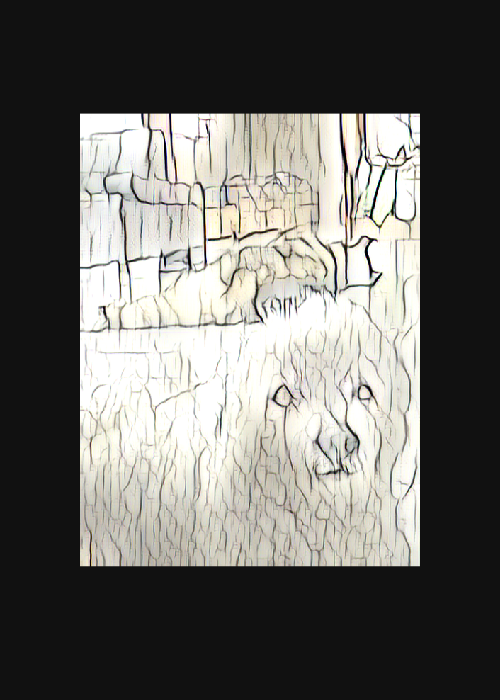

In [5]:
content = '/mnt/s/CV/StyleTransferData/test2015/COCO_test2015_000000000083.jpg'
style = '/mnt/s/CV/StyleTransferData/wikiart_styles/100027.jpg'
result = get_prediction(content, style)
px.imshow(
    result,
    template='plotly_dark', 
    width=500, 
    height=700
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
).show('png')